In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp

from sklearn.decomposition import PCA

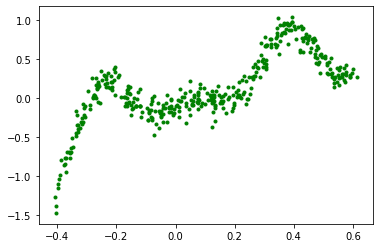

In [2]:
x = np.linspace(0,1,400)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
sortindx = np.argsort(x)
x = x[sortindx]
y = y[sortindx]
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
xy = np.c_[xx,yy]
plt.scatter(x, y, marker='.', color='g')

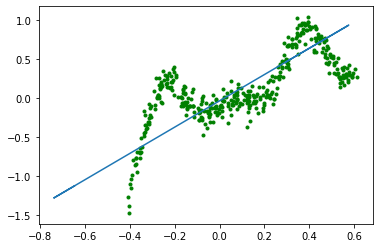

In [3]:
## Actual PCA/AE
#Instantiate a PCA model, the run fit_transform to xy followed by inverse_transform
pca=PCA(n_components=1)
xy_pca=pca.fit_transform(xy)
xy_n=pca.inverse_transform(xy_pca)

plt.scatter(x, y, marker='.', color='g')
plt.plot(xy_n[:, 0], xy_n[:,1])

In [4]:
pca.singular_values_

array([9.65164948])

## Reverse Function 

In [5]:
def reverse0(self:tsp.Spline1D, y):
    x = np.zeros_like(self.input)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x += xpossible*self.rangeX[i]
    return x

In [6]:
def reverse_spline_vector(self:tsp.SplineVectorLayer, y):
    recons = np.empty_like(self.input)
    for i in range(self.dimension):
        yi = y[:, i]
        reconsi = reverse0(self.spline_list[i], yi)
        recons[:, i] = reconsi
    return recons

In [7]:
def _backward_target_(self:tsp.Spline1D, del_recons):
    dtarg = np.zeros_like(self.output)
    for i in range(self.n_points-1):
        dtarg = dtarg + self.diffX[i]/self.diffY[i] *self.rangeX[i]

    dtarg = dtarg*del_recons
    return dtarg

def backward_reverse_spline_vector(self:tsp.SplineVectorLayer, del_recons):
    del_targ = np.empty_like(self.output)
    for i in range(self.dimension):
        del_reconsi = del_recons[:,i]
        del_targi = _backward_target_(self.spline_list[i], del_reconsi)
        del_targ[:, i] = del_targi
    return del_targ

## Network

In [8]:
max_points = 2
lr=0.01
layer1 = tsp.SplineVectorLayer(2, max_points)
layer2 = tnn.WeightsLayer(2,1, optimizer=tnn.SGD(0.01))
layer2i = tnn.WeightsLayer(1,2)

## Doing the optimization continuously

_______________________
Steps 0
Error 0.18340564964338554


_______________________
Steps 10
Error 0.16185631501258968


_______________________
Steps 20
Error 0.15153322204663525


_______________________
Steps 30
Error 0.14549154918528384


_______________________
Steps 40
Error 0.1415315532324977


_______________________
Steps 50
Error 0.1387540339245599


_______________________
Steps 60
Error 0.13671709249914532


_______________________
Steps 70
Error 0.13517591202357404


_______________________
Steps 80
Error 0.13398292272438192


_______________________
Steps 90
Error 0.13304343059940626


_______________________
Steps 100
Error 0.13229367430196082


_______________________
Steps 110
Error 0.13168905434594735


_______________________
Steps 120
Error 0.13119740090400886


_______________________
Steps 130
Error 0.13079491809099703


_______________________
Steps 140
Error 0.13046363324139443


_______________________
Steps 150
Error 0.1301897334094141


______________________

TclError: invalid command name "pyimage10"

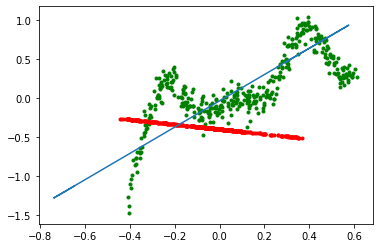

In [9]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(10000):

    a1 = layer1.forward(xy)
    z = layer2.forward(a1)
#     layer2i.weights = layer2.weights.T
    layer2i.weights = np.linalg.pinv(layer2.weights)
    a1i = layer2i.forward(z)
    xyi = reverse_spline_vector(layer1, a1i)
    
    dxy = tnn.MseLoss.del_loss(xyi, xy)
    error = tnn.MseLoss.loss(xyi, xy)
    da1i = backward_reverse_spline_vector(layer1, dxy)
    dz = layer2i.backward(da1i)
    da1 = layer2.backward(dz)
    dxy = layer1.backward(da1)
    
    layer1.update(lr)
    layer2.update()
    
    if step % 100 == 0:
        layer1._maintain_good_spline_()
        
    if step % 10 == 0:            
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        
        ax.clear()
#         epsilon=0.4
#         plt.xlim(x.min()-epsilon, x.max()+epsilon)
#         plt.ylim(y.min()-epsilon, y.max()+epsilon)
        plt.scatter(x, y, marker='.', color='g')
        plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
        plt.plot(xy_n[:, 0], xy_n[:,1])
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

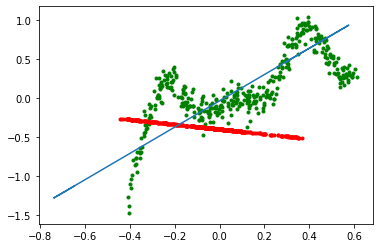

In [10]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
plt.plot(xy_n[:, 0], xy_n[:,1])

## doing by different inverse layer1

In [11]:
layer1 = tsp.SplineVectorLayer(2, max_points)
layer2 = tnn.WeightsLayer(2,1, optimizer=tnn.SGD(0.01))
layer2i = tnn.WeightsLayer(1,2, optimizer=tnn.SGD(0.01))
layer1i = tsp.SplineVectorLayer(2, max_points)

_______________________
Steps 0
Error 0.09124573020537344


_______________________
Steps 10
Error 0.08776360642498915


_______________________
Steps 20
Error 0.08461227382871606


_______________________
Steps 30
Error 0.08176218901198695


_______________________
Steps 40
Error 0.07918648991277727


_______________________
Steps 50
Error 0.0768606894723149


_______________________
Steps 60
Error 0.07476238986639193


_______________________
Steps 70
Error 0.07287104316445546


_______________________
Steps 80
Error 0.07116775167097825


_______________________
Steps 90
Error 0.06963510199797111


_______________________
Steps 100
Error 0.06825702753223603


_______________________
Steps 110
Error 0.0670186944731757


_______________________
Steps 120
Error 0.06590640708033742


_______________________
Steps 130
Error 0.06490752821897237


_______________________
Steps 140
Error 0.0640104117456709


_______________________
Steps 150
Error 0.06320434374093796


______________________



_______________________
Steps 1330
Error 0.03665374361337533


_______________________
Steps 1340
Error 0.03650814177553254


_______________________
Steps 1350
Error 0.03636351416180335


_______________________
Steps 1360
Error 0.03621980910445316


_______________________
Steps 1370
Error 0.03607697489731969


_______________________
Steps 1380
Error 0.03593495992482124


_______________________
Steps 1390
Error 0.035793712797997944


_______________________
Steps 1400
Error 0.035653182491526846


_______________________
Steps 1410
Error 0.035513318477776924


_______________________
Steps 1420
Error 0.03537407085536645


_______________________
Steps 1430
Error 0.03523539047061041


_______________________
Steps 1440
Error 0.03509722903086424


_______________________
Steps 1450
Error 0.0349595392091904


_______________________
Steps 1460
Error 0.0348222747400646


_______________________
Steps 1470
Error 0.03468539050604367


_______________________
Steps 1480
Error 0.034548842

TclError: invalid command name "pyimage30"

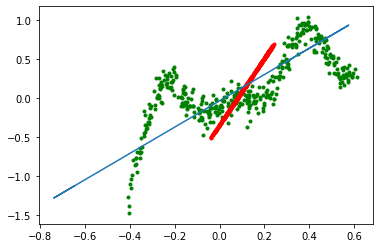

In [12]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(10000):

    a1 = layer1.forward(xy)
    z = layer2.forward(a1)
#     layer2i.weights = layer2.weights.T
#     layer2i.weights = np.linalg.pinv(layer2.weights)
    a1i = layer2i.forward(z)
    xyi = layer1i.forward(a1i)
    
    dxy = tnn.MseLoss.del_loss(xyi, xy)
    error = tnn.MseLoss.loss(xyi, xy)
    da1i = layer1i.backward(dxy)
    dz = layer2i.backward(da1i)
    da1 = layer2.backward(dz)
    dxy = layer1.backward(da1)
    
    layer1.update(lr)
    layer2.update()
    layer2i.update()
    layer1i.update(lr)
    
    if step % 100 == 0:
        layer1._maintain_good_spline_()
        
    if step % 10 == 0:            
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        
        ax.clear()
#         epsilon=0.4
#         plt.xlim(x.min()-epsilon, x.max()+epsilon)
#         plt.ylim(y.min()-epsilon, y.max()+epsilon)
        plt.scatter(x, y, marker='.', color='g')
        plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
        plt.plot(xy_n[:, 0], xy_n[:,1])
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

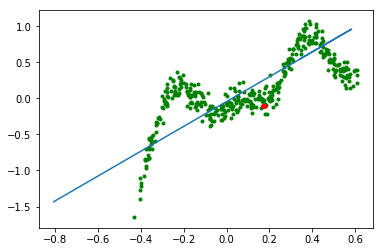

In [23]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
plt.plot(xy_n[:, 0], xy_n[:,1])

In [26]:
dir(spline)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_increase_pieces_',
 '_maintain_good_spline_',
 'backward',
 'del_output',
 'forward',
 'input',
 'input_dim',
 'output',
 'output_dim',
 'spline_mat',
 'update']

## doing by using splines only !!

In [19]:
max_points = 4
lr=0.1
spline = tsp.SplineMatrixLayer(2,1, max_points=2)
splinei = tsp.SplineMatrixLayer(1,2, max_points=2)
spline._increase_pieces_(max_points-2)
splinei._increase_pieces_(max_points-2)

In [20]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(10000):

    a1 = spline.forward(xy)
    xyi = splinei.forward(a1)
    
    dxy = tnn.MseLoss.del_loss(xyi, xy)
    error = tnn.MseLoss.loss(xyi, xy)

    
    da1 = splinei.backward(dxy)
    dxy = spline.backward(da1)
    
    spline.update(lr)
    splinei.update(lr)
    
    if step % 1000 == 0 and step!=0:
        spline._maintain_good_spline_()
        splinei._maintain_good_spline_()
        
        
    if step % 10 == 0:            
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        
        ax.clear()
#         epsilon=0.4
#         plt.xlim(x.min()-epsilon, x.max()+epsilon)
#         plt.ylim(y.min()-epsilon, y.max()+epsilon)
        plt.scatter(x, y, marker='.', color='g')
        plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
        plt.plot(xy_n[:, 0], xy_n[:,1])
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
Steps 0
Error 0.06770927577590717


_______________________
Steps 10
Error 0.06314847918266465


_______________________
Steps 20
Error 0.06101710662631617


_______________________
Steps 30
Error 0.05961000616594337


_______________________
Steps 40
Error 0.05832470746129724


_______________________
Steps 50
Error 0.056940060508985674


_______________________
Steps 60
Error 0.05536312423288187


_______________________
Steps 70
Error 0.05354216271259659


_______________________
Steps 80
Error 0.05143827657886781


_______________________
Steps 90
Error 0.04901769908889388


_______________________
Steps 100
Error 0.046259088561678506


_______________________
Steps 110
Error 0.04321037670231922


_______________________
Steps 120
Error 0.039813890024583555


_______________________
Steps 130
Error 0.036092856408057046


_______________________
Steps 140
Error 0.03225105730441502


_______________________
Steps 150
Error 0.028407787433630573


______________

TclError: invalid command name "pyimage116"

In [ ]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
plt.plot(xy_n[:, 0], xy_n[:,1])

## spline matrix and spline vector

In [21]:
max_points = 4
lr=0.1
spline = tsp.SplineMatrixLayer(2,1, max_points=2)
func1d = tsp.SplineVectorLayer(1, max_points=2)
splinei = tsp.SplineMatrixLayer(1,2, max_points=2)
spline._increase_pieces_(max_points-2)
splinei._increase_pieces_(max_points-2)

In [22]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(10000):

    a1 = spline.forward(xy)
    a2 = func1d.forward(a1)
    xyi = splinei.forward(a2)
    
    dxy = tnn.MseLoss.del_loss(xyi, xy)
    error = tnn.MseLoss.loss(xyi, xy)

    
    da2 = splinei.backward(dxy)
    da1 = func1d.backward(da2)
    dxy = spline.backward(da1)
    
    spline.update(lr)
    func1d.update(lr)
    splinei.update(lr)
    
    if step % 100 == 0 and step!=0:
        spline._maintain_good_spline_()
        splinei._maintain_good_spline_()
        
        
    if step % 10 == 0:            
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        
        ax.clear()
#         epsilon=0.4
#         plt.xlim(x.min()-epsilon, x.max()+epsilon)
#         plt.ylim(y.min()-epsilon, y.max()+epsilon)
        plt.scatter(x, y, marker='.', color='g')
        plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
        plt.plot(xy_n[:, 0], xy_n[:,1])
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
Steps 0
Error 0.10264187930917597


_______________________
Steps 10
Error 0.07869465022953036


_______________________
Steps 20
Error 0.0704150274265694


_______________________
Steps 30
Error 0.06751990051042628


_______________________
Steps 40
Error 0.06650177213366965


_______________________
Steps 50
Error 0.06614187828897147


_______________________
Steps 60
Error 0.06601344837551415


_______________________
Steps 70
Error 0.065966494980493


_______________________
Steps 80
Error 0.0659482077987615


_______________________
Steps 90
Error 0.06593997394651469


_______________________
Steps 100
Error 0.06593522903040497


_______________________
Steps 110
Error 0.06597373012281181


_______________________
Steps 120
Error 0.06594658482763259


_______________________
Steps 130
Error 0.06593642606565121


_______________________
Steps 140
Error 0.06593060303563995


_______________________
Steps 150
Error 0.06592581291298014


_______________________



_______________________
Steps 1320
Error 0.005584512491077065


_______________________
Steps 1330
Error 0.005571830459103756


_______________________
Steps 1340
Error 0.005559001420321238


_______________________
Steps 1350
Error 0.0055480553245379


_______________________
Steps 1360
Error 0.0055393678305242135


TclError: invalid command name "pyimage136"

In [ ]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(xyi[:,0],xyi[:,1], marker='.', color='r')
plt.plot(xy_n[:, 0], xy_n[:,1])